<a href="https://colab.research.google.com/github/nikiska77/ydata-viz-ai/blob/main/NN_sharing_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#install packages

In [ ]:

!pip install wget
!pip install -U git+https://github.com/pydicom/pydicom.git
#pip install --no-cache-dir git+https://github.com/pydicom/pydicom.git
!pip install python-gdcm

!pip install torchsummary 



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=c67c67e7ff52eaeb684beb3f73b41a90d553ca6c089b5fbad68cbe4de02ea50f
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pydicom/pydicom.git to /tmp/pip-req-build-r53uhmds
  Running command git clone -q https://github.com/pydicom/pydicom.git /tmp/pip-req-build-r53uhmds
  Created wheel for pydicom: filename=pydicom-2.4.0.dev0-py3-none-any.whl size=1966307 sha256=cff856b87420e8adeb3a45bac53d2d0dabdbdbed4142c4959fd9c35bfb8d216e
  Stored in directory: /tmp/pip-ephem-wheel-cache-1q_jg937/wheels/8a/75/6f/a3a81ff6d9eaa04f50d99238b899485b32c5948527a33b243c
Successfully built pydicom
Looking in indexes: https://pypi.org/s

In [ ]:
import dicom_utils as dcm
import Affine3D as affine
from scipy.ndimage import affine_transform

In [ ]:
#input_file = "/Users/boriskefer/Documents/coding/YDATA/2021_2022_main/viz_ai/ydata-viz-ai/YdataDataset.txt" 
#data_path = "/Users/boriskefer/Documents/coding/YDATA/2021_2022_main/viz_ai/ydata-viz-ai/data03_01"

In [ ]:
#to work from Colab and google disk:
from google.colab import drive 
from pathlib import Path
import os

drive.mount('/content/drive')

home_path = Path("/content/drive/MyDrive/VIZ/data/data03_01")
#data_path = os.path.join(home_path, "data")
#print(data_path)

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import copy

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.utils import make_grid

#Model

In [ ]:
x = torch.rand(1,3,64,64) # input x
y = torch.rand(1,3,64,64) # input y
cnn = nn.Conv2d(3,10,kernel_size=5) # network
input = torch.cat((x,y),dim=0) # stack them batch-wise
output = cnn(input) # pass both x and y through the network as a single pass
x_out = output[0] # get the output of x
y_out = output[1] # get the output of y

#Dataset creation (dataloader)

In [ ]:
def normalize(img, min_val, max_val):
    return (img - min_val) / (max_val - min_val)

def transform(img, angle):
    m = affine.Affine3dRotateCenterMatrix(angle, img.shape, axis=2)
    return affine_transform(img, m), m


class Img3dDataSet(Dataset):
    def __init__(self, data_path, min_val, max_val):
        self.d_path = data_path
        self.min_val = min_val
        self.max_val = max_val
        self.transform = None
        self.target_transform = None
        names = [f for f in os.listdir(data_path) if f.endswith(".npz")]
        self.names_array = np.sort(np.array(names))
        
    def __getitem__(self, idx):
        name = self.names_array[idx]
        img3d = np.load(os.path.join(self.d_path, name))['I']
        img3d = normalize(img3d, self.min_val, self.max_val)
        # transform original image twice
        alpha1 = np.random.randint(-45, 45)
        label, m1 = transform(img3d, alpha1)
        alpha2 = np.random.randint(-45, 45)
        img3d, m2 = transform(img3d, alpha2)

        # find transform matrix from 1st to 2nd
        matrix = affine.Affine3dRotateCenterMatrix(alpha2 - alpha1, img3d.shape, axis=2)
        matrix = matrix[:3, :]

        print(label.shape, matrix.shape)
        print(matrix)
        #label = label.transpose(2, 0, 1)
        label = np.expand_dims(label, axis=0)
        label = torch.from_numpy(label).float()
        #adding this to get the dimensions nedded
        img3d = np.expand_dims(img3d, axis=0)
        item = torch.from_numpy(img3d).float()
        return item, label, matrix
    
    def __len__(self):
        return len(self.names_array)

In [ ]:
dataset = Img3dDataSet(home_path, -1000, 1000)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
%%time
x, y, matrix = next(iter(dataloader))

(320, 320, 20) (3, 4)
[[ 1.04528464e-01  9.94521916e-01  0.00000000e+00 -1.58480606e+01]
 [-9.94521916e-01  1.04528464e-01  0.00000000e+00  3.02398956e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]]
CPU times: user 1.5 s, sys: 5.93 ms, total: 1.51 s
Wall time: 1.94 s


In [ ]:
x.shape, y.shape, matrix.shape

(torch.Size([1, 1, 320, 320, 20]),
 torch.Size([1, 1, 320, 320, 20]),
 torch.Size([1, 3, 4]))

In [ ]:
a = x[:,:,:,:,0]
a.shape
b = x[0,0,0,0,:]
b.shape

torch.Size([20])

In [ ]:
matrix1 = matrix[:,:3,:]

tensor([[[  0.7880,  -0.6157,   0.0000, 132.4241],
         [  0.6157,   0.7880,   0.0000, -64.5876],
         [  0.0000,   0.0000,   1.0000,   0.0000]]])

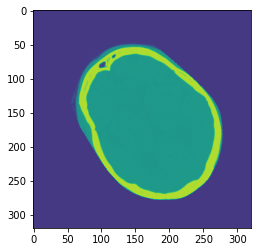

In [ ]:
#x.shape = x.unsqueeze(0)
plt.imshow(x.squeeze()[:,:,10])

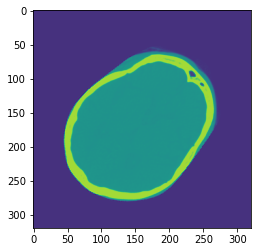

In [ ]:
#y = y.unsqueeze(0)
#y.shape
plt.imshow(y.squeeze()[:,:,10])

#Running model

###Siamese network

### Last code version

In [ ]:
class Dense_Block2D(nn.Module):
  def __init__(self, in_channels, growthRate):
    super(Dense_Block2D, self).__init__()   
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.relu = nn.ReLU(inplace = True)
    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels=growthRate, kernel_size = 3, stride = 1, padding = 1)

  def forward(self, x):
      out = self.conv1(self.relu(self.bn1(x)))
      return torch.cat((x, out), 1)

class Dense_Block3D(nn.Module):
  def __init__(self, in_channels, growthRate):
    super(Dense_Block3D, self).__init__()
    self.bn1 = nn.BatchNorm3d(in_channels)
    self.relu = nn.ReLU(inplace = True)
    self.conv1 = nn.Conv3d(in_channels = in_channels, out_channels = growthRate, kernel_size = 3, stride = 1, padding = 1)

  def forward(self, x):
      out = self.conv1(self.relu(self.bn1(x)))
      return torch.cat((x, out), 1)

class Transition_Layer2d(nn.Module): 
  def __init__(self, in_channels, out_channels):
    super(Transition_Layer2d, self).__init__() 
    self.bn = nn.BatchNorm2d(in_channels) 
    self.relu = nn.ReLU(inplace = True) 
    self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, stride=1, padding = 0) 
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

  def forward(self, x): 
    bn = self.relu(self.bn(x))
    out = self.conv(bn) 
    out = self.max_pool(out) 
    return out 

class Transition_Layer3d(nn.Module): 
  def __init__(self, in_channels, out_channels):
    super(Transition_Layer3d, self).__init__() 
    self.bn = nn.BatchNorm3d(in_channels) 
    self.relu = nn.ReLU(inplace = True) 
    self.conv = nn.Conv3d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, stride=1, padding = 0) 
    self.max_pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)

  def forward(self, x): 
    bn = self.bn(x)
    out = self.relu(bn)
    out = self.conv(out)
    out = self.max_pool(out) 
    return out 



class Siam_AirNet2(nn.Module):
    def __init__(self, growthRate=8, num_init_features=8, bn_size=1, block_config2D=(1, 2, 4), block_config3D=(8, 16, 32)):
        super(Siam_AirNet2, self).__init__()
        self.flatten = nn.Flatten()
        
        self.firstlayer = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=growthRate,kernel_size=3,stride=1,padding=1), #(320 - 3 + 2*1)/1 + 1 = 320
            nn.BatchNorm2d(growthRate), #can't understand should we use here BN or not and if yes - in which order
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) #(320 - 2)/2 + 1 = 160
        self.dense2D = nn.Sequential()
        self.dense3D = nn.Sequential()

        # Make 2D Dense Blocks and followed by Transition blocks         
        for i, num_layers in enumerate(block_config2D):
          inChannels = num_layers * growthRate
          block = self._make_dense2D(inChannels, growthRate, num_layers)
          self.dense2D.add_module('dense2D%d' % (i + 1), block)          
          trans = Transition_Layer2d(inChannels + num_layers* growthRate, inChannels+ num_layers* growthRate)
          self.dense2D.add_module('trans2D%d' % (i + 1), trans)          
        
        # Make 3D Dense Blocks and followed by Transition blocks         
        for i, num_layers in enumerate(block_config3D):
          inChannels= num_layers * growthRate
          #num_input_features + i * growth_rate
          block = self._make_dense3D(inChannels, growthRate, num_layers)       
          self.dense3D.add_module('dense3D%d' % (i + 1), block)                
          trans = Transition_Layer3d(inChannels + num_layers* growthRate, inChannels + num_layers* growthRate)
          self.dense3D.add_module('trans3D%d' % (i + 1), trans)          

        self.regression = nn.Sequential(
            nn.Linear(2*2*2*512*2, 1024),  #check the final dimensions
#            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
 #           nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
  #          nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
   #         nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 12))   


    def _make_dense2D(self, inChannels, growthRate, nDenseBlocks):
        layers = []
        for i in range(int(nDenseBlocks)):
            layers.append(Dense_Block2D(inChannels, growthRate))
            inChannels += growthRate
        return nn.Sequential(*layers)


    def _make_dense3D(self, inChannels, growthRate, nDenseBlocks):
        layers = []
        for i in range(int(nDenseBlocks)):
            layers.append(Dense_Block3D(inChannels, growthRate))
            inChannels += growthRate
        return nn.Sequential(*layers)



    def forward_2D(self, x):
        # This function will be called for both images
        output = self.firstlayer(x)
        #dense block here should be done on the same size (160x160) of FM as in previous layer
        output = self.dense2D(output)
        #and now we are here.... 3D green part
        return output 

    def forward_3D(self, x):        
        output = self.dense3D(x)
        #it is expected 2x2x2x512
        output = self.flatten(output)        
        return output

    def forward(self, input_t, input_ref):
        # In this function we pass in both images and obtain both vectors
        n_batches = input_t.shape[0]
        z_dim = 20
        x_y_dim = input_t.shape[-2]
        input_t = input_t.view(n_batches * z_dim, 1, x_y_dim, x_y_dim)
        input_ref = input_ref.view(n_batches * z_dim, 1, x_y_dim, x_y_dim)
        x_t = self.forward_2D(input_t)
        #print('Shape x_t after 2D ', x_t.shape) #Shape x_t after 2D  torch.Size([20, 64, 20, 20])
        x_ref = self.forward_2D(input_ref)
        #then concatenate the output for every 20 slices 
        x_t = x_t.view(n_batches, x_t.shape[1], int(x_t.shape[0]/n_batches), x_t.shape[-2], x_t.shape[-2]) 
        #print('Shape x_t after reshaping before 3D ', x_t.shape)
        x_ref = x_ref.view(n_batches, x_ref.shape[1], int(x_ref.shape[0]/n_batches), x_ref.shape[-2], x_ref.shape[-2]) 
        x_t = self.forward_3D(x_t)
        x_ref = self.forward_3D(x_ref)
        #print('x_t and x_ref.shape', x_t.shape, x_ref.shape)
        input_conc = torch.cat((x_t,x_ref),dim=1)
        #print(input_conc.shape)
        res = self.regression(input_conc)
        return res 



'''
        for i, num_layers in enumerate(block_config2D):
          inChannels= growthRate
          #inChannels= num_layers*growthRate
          block = self._make_dense2D(inChannels, growthRate, num_layers)
          self.dense2D.append(block)          
          trans = Transition_Layer2d(inChannels, inChannels)
          self.dense2D.append(trans)
        
        for i, num_layers in enumerate(block_config3D):
          inChannels= growthRate
          #num_input_features + i * growth_rate
          block = self._make_dense3D(inChannels, growthRate, num_layers)       
          self.dense3D.append(block)          
          tran = Transition_Layer3d(inChannels, inChannels)
          self.dense3D.append(tran)          
'''

'\n        for i, num_layers in enumerate(block_config2D):\n          inChannels= growthRate\n          #inChannels= num_layers*growthRate\n          block = self._make_dense2D(inChannels, growthRate, num_layers)\n          self.dense2D.append(block)          \n          trans = Transition_Layer2d(inChannels, inChannels)\n          self.dense2D.append(trans)\n        \n        for i, num_layers in enumerate(block_config3D):\n          inChannels= growthRate\n          #num_input_features + i * growth_rate\n          block = self._make_dense3D(inChannels, growthRate, num_layers)       \n          self.dense3D.append(block)          \n          tran = Transition_Layer3d(inChannels, inChannels)\n          self.dense3D.append(tran)          \n'

In [ ]:
 model2 = Siam_AirNet2()
 model2

Siam_AirNet2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (firstlayer): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense2D): Sequential(
    (dense2D1): Sequential(
      (0): Dense_Block2D(
        (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (trans2D1): Transition_Layer2d(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (den

In [ ]:
model2 = Siam_AirNet2()
model2.train()
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model2.parameters(), lr = 0.005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
num_epochs = 200



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch number 0
 Current loss 91732.8046875

Epoch number 1
 Current loss 70227.875

Epoch number 2
 Current loss 737651.1875

Epoch number 3
 Current loss 50466.6171875

Epoch number 4
 Current loss 86122.9140625

Epoch number 5
 Current loss 89951.5625

Epoch number 6
 Current loss 77225.046875

Epoch number 7
 Current loss 48177.5625

Epoch number 8
 Current loss 37738.55859375

Epoch number 9
 Current loss 7472.93017578125

Epoch number 10
 Current loss 11029.279296875

Epoch number 11
 Current loss 9826.3369140625

Epoch number 12
 Current loss 3708.105712890625

Epoch number 13
 Current loss 4221.650390625

Epoch number 14
 Current loss 5324.4501953125

Epoch number 15
 Current loss 3962.5302734375

Epoch number 16
 Current loss 2475.63623046875

Epoch number 17
 Current loss 1575.637451171875

Epoch number 18
 Current loss 954.4137573242188

Epoch number 19
 Current loss 1045.124267578125

Epoch number 20
 Current loss 1223.919921875

Epoch number 21
 Current loss 1056.0535888671

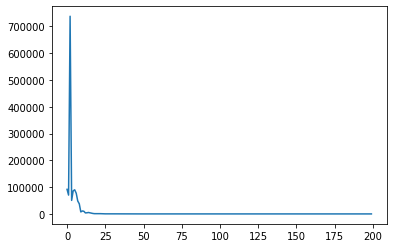

<All keys matched successfully>

In [ ]:
best_loss = np.inf
loss_history = [] 
best_model_wts2 = copy.deepcopy(model2.state_dict())

# Iterate throught the epochs
for epoch in range(num_epochs):

    # Iterate over batches
#    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
 #       img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
  

        # Zero the gradients
        optimizer.zero_grad()
#        print('shapes x y', x.shape, y.shape)
        # Pass in the two images into the network and obtain two outputs
        res = model2(x, y)
 #       print(res)

        # Pass the outputs of the networks and label into the loss function
        loss = criterion(res, matrix.flatten())
        # Calculate the backpropagation
        loss.backward()

        # Optimize
        optimizer.step()
        scheduler.step() 
        # Every 10 batches print out the loss
#        if i % 10 == 0 :
        print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
        #iteration_number += 10

        if loss < best_loss:
          best_loss = loss
          best_model_wts2 = copy.deepcopy(model2.state_dict())

        loss_history.append(loss.item())
print(f'Best loss {best_loss}')

plt.plot(range(num_epochs),loss_history)
plt.show()
model2.load_state_dict(best_model_wts2)


### Results check

the input


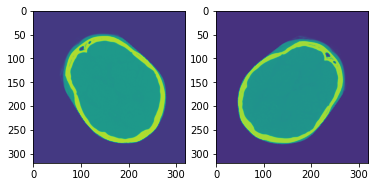

In [ ]:
#Printing the initial input and output
print('the input')
fig = plt.subplots(1,2)
plt.subplot(1,2,1)
x_to_print = x.squeeze().numpy()
#x_to_print = x_to_print.transpose(1, 2, 0)
plt.imshow(x_to_print[:,:,10])
plt.subplot(1,2,2)
y_to_print = y.squeeze().numpy()
#y_to_print = y_to_print.transpose(1, 2, 0)
plt.imshow(y_to_print[:,:,10])





the output of the model
Final MSE error: 3.695887684784793e-08
Let us compare label and output of the model (we will apply resulting natrix on x_input)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([3, 4])) that is different to the input size (torch.Size([1, 3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


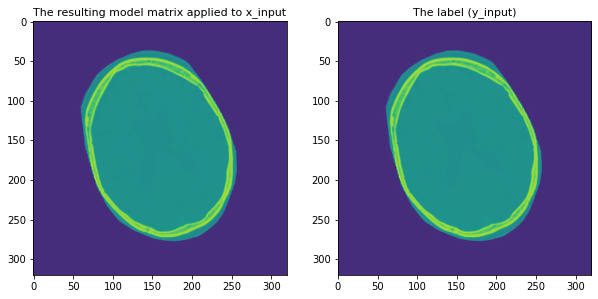

In [ ]:
print('the output of the model')
#model.load_state_dict(best_model_wts)
matrix_output = model(x, y)

#matrix_output = torch.tensor([ 9.2041e-01,  3.9060e-01, -4.6968e-05, -4.9798e+01, -3.9079e-01,
 #        9.2044e-01,  9.8165e-05,  7.5236e+01,  5.0508e-05, -1.2242e-04,
  #       9.9987e-01, -2.5560e-04], requires_grad=False)
matrix_output = matrix_output.reshape(3,4)
mse=nn.MSELoss()
print(f'Final MSE error: {mse(matrix, matrix_output)}')

matrix_output = matrix_output.detach().numpy()
print('Let us compare label and output of the model (we will apply resulting natrix on x_input)')
fig = plt.subplots(1,2, figsize=(10, 5))
plt.subplot(1,2,1)
y_new = affine_transform(x_to_print, matrix_output)
plt.title('The resulting model matrix applied to x_input',fontdict={'fontsize':11})
plt.imshow(y_new[:,:,10])
plt.subplot(1,2,2)
plt.title('The label (y_input)', fontdict={'fontsize':11})
plt.imshow(y_to_print[:,:,10])
plt.show()

### Model output check

the input


torch.Size([1, 1, 320, 320, 20])

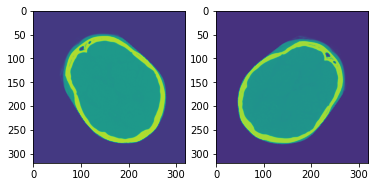

In [ ]:
#Printing the initial input and output
print('the input')
fig = plt.subplots(1,2)
plt.subplot(1,2,1)
x_to_print = x.numpy().squeeze()
plt.imshow(x_to_print[:,:,10])
plt.subplot(1,2,2)
y_to_print = y.numpy().squeeze()
plt.imshow(y_to_print[:,:,10])



x.shape

the output of the model
Final MSE error: 1.313487700826954e-07
Let us compare label and output of the model (we will apply resulting natrix on x_input)


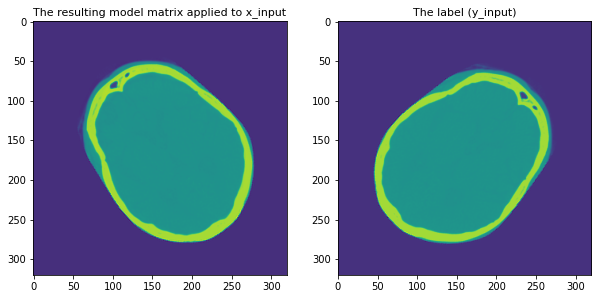

In [ ]:
print('the output of the model')
#model2.load_state_dict(best_model_wts2)
matrix_output2 = model2(x, y)
matrix_output2 = matrix_output2.reshape(3,4)

mse=nn.MSELoss()
print(f'Final MSE error: {mse(matrix.flatten().reshape(3,4), matrix_output2)}')

matrix_output2 = matrix_output2.detach().numpy()
x_new = affine.affine_transform(y_to_print, matrix_output2)
print('Let us compare label and output of the model (we will apply resulting matrix on x_input)')
fig = plt.subplots(1,2, figsize=(10, 5))
plt.subplot(1,2,1)
plt.title('The resulting model matrix applied to x_input',fontdict={'fontsize':11})
plt.imshow(x_new[:,:,10])
plt.subplot(1,2,2)
plt.title('The label (y_input)', fontdict={'fontsize':11})
plt.imshow(y_to_print[:,:,10])
plt.show()

In [ ]:
matrix_output2
x_to_print

tensor([[ 9.8493e-01,  1.9222e-01, -6.4763e-04, -2.7589e+01, -1.8764e-01,
          9.8991e-01,  2.3975e-03,  3.3471e+01, -5.6748e-03,  6.7478e-03,
          9.8988e-01,  4.7317e-03]], grad_fn=<AddmmBackward0>)

In [ ]:
matrix

tensor([[[  0.9816,   0.1908,   0.0000, -27.5898],
         [ -0.1908,   0.9816,   0.0000,  33.4691],
         [  0.0000,   0.0000,   1.0000,   0.0000]]])

In [ ]:
x_to_print.shape

y_new2 = affine.affine_transform(x_to_print, matrix_output2.detach().numpy())